In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# extracting data and doing the fit on velocity

In [2]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    file_exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

In [3]:
def deco(axs) :
    axs.axvspan(arg.StimulusOn-start, arg.StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(arg.StimulusOf-start, arg.TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(arg.TargetOn-start, arg.TargetOff-start, color='k', alpha=0.15)
    for s in range(len(arg.saccades)) :
        axs.axvspan(arg.saccades[s][0]-start, arg.saccades[s][1]-start, color='k', alpha=0.2)

In [4]:
def regress(ax, p, data, minx, miny, maxx, maxy, t_label=12) :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c='k', linewidth=2)
    ax.text(maxx-((maxx-minx)/16.180),miny+((maxy-miny)/10), 'r = %0.3f'%(r_), fontsize=t_label/1.2, ha='right')

    return ax

In [5]:
def position(x, bino, start_anti, v_anti, latence, tau, maxi, trial_data, px_per_deg, nan=False, avant=5, apres=10):
    saccades = data[trial_data]['events']['Esac'] #[starttime, endtime, duration, startx, starty, endx, endy]
    data_x = data[trial_data]['x']
    
    #gradient_deg = gradient_x * 1/px_per_deg * 1000 # gradient en deg/sec
    ms = 1000
    v_anti = (v_anti/ms) # pour passer de sec à ms
    maxi = maxi /ms
    
    speed = ANEMO.fct_exponentiel(x, bino, start_anti, v_anti, latence, tau, maxi)
    pos = np.cumsum(speed)

    if nan == True :
        avant, apres =  5, 10 #15
        for sacc in saccades :
            if sacc[0]-t_0 < len(pos) :
                if sacc[0]-t_0 > int(latence) :
                    if int(sacc[1]-t_0)+apres <= len(pos) :
                        pos[int(sacc[0]-t_0)-avant:int(sacc[1]-t_0)+apres] = np.nan 
                        pos[int(sacc[1]-t_0)+apres:] += ((data_x[int(sacc[1]-t_0)+apres]-data_x[int(sacc[0]-t_0)-avant-1])/px_per_deg) - np.mean(speed[int(sacc[0]-t_0):int(sacc[1]-t_0)]) * sacc[2]

                    else :
                        pos[int(sacc[0]-t_0)-avant:] = np.nan
 
    return pos

# doing the fit

In [6]:
def Fit_position(position_x, trackertime, bino, trial_data, TargetOn, StimulusOf, saccades,
                 px_per_deg, param_fit=None, sup=False, time_sup=-280, step=2, nan=True) :

    from lmfit import  Model, Parameters

    t_0 = trackertime[0]

    if param_fit is None :
        param_fit={'tau':[15.,13.,80.], 'maxi':[15.,1.,40], 'v_anti':[0.,-40.,40.],
                   'latence':[TargetOn-t_0+100,TargetOn-t_0+75,'STOP'],
                   'start_anti':[TargetOn-t_0-100, StimulusOf-t_0-200, TargetOn-t_0+75]}

    if param_fit['latence'][2]=='STOP' :
        stop_latence = []
        for s in range(len(saccades)) :
            if (saccades[s][0]-t_0) >= (TargetOn-t_0+100) :
                stop_latence.append((saccades[s][0]-t_0))
        if stop_latence==[] :
            stop_latence.append(len(trackertime))
        stop = stop_latence[0]
    else :
        stop = param_fit['latence'][2]


    if sup==True :
        position_x = position_x[:time_sup]
        trackertime = trackertime[:time_sup]
    
    model = Model(position)

    params = Parameters()

    if step == 1 :
        vary = True
    elif step == 2 :
        vary = False

    params.add('nan', value=nan, vary=False)
    params.add('bino', value=bino, vary=False)
    params.add('trial_data', value=trial_data, vary=False)
    params.add('avant', value=5, vary=False)
    params.add('apres', value=10, vary=False)
    params.add('px_per_deg', value=px_per_deg, vary=False)

    
    params.add('maxi', value=param_fit['maxi'][0], min=param_fit['maxi'][1], max=param_fit['maxi'][2])
    params.add('latence', value=param_fit['latence'][0], min=param_fit['latence'][1], max=stop)
    params.add('tau', value=param_fit['tau'][0], min=param_fit['tau'][1], max=param_fit['tau'][2], vary=vary)
    params.add('start_anti', value=param_fit['start_anti'][0], min=param_fit['start_anti'][1], max=param_fit['start_anti'][2], vary=vary)
    params.add('v_anti', value=param_fit['v_anti'][0], min=param_fit['v_anti'][1], max=param_fit['v_anti'][2], vary=vary)

    if step == 1 :
        result_deg = model.fit(position_x, params, x=np.arange(len(trackertime)), nan_policy='omit')

    elif step == 2 :
        out = model.fit(position_x, params, x=np.arange(len(trackertime)), nan_policy='omit')
        out.params['tau'].set(vary=True)
        out.params['start_anti'].set(vary=True)
        out.params['v_anti'].set(vary=True)

        result_deg = model.fit(position_x, out.params, x=np.arange(len(trackertime)), method='nelder', nan_policy='omit')
                                
    return result_deg

In [7]:
from ANEMO import ANEMO

block, trial = 0, 14
arg = ANEMO.arg(data, file_exp, trial, block)


trial_data = trial + arg.N_trials*block
time, t_0 = arg.trackertime, arg.trackertime_0
start, start1 = arg.TargetOn, arg.TargetOn-t_0

data_1 = (arg.data_x-(arg.data_x[arg.StimulusOf-t_0])) / arg.px_per_deg

kwarg_0 = {'trial_data' : trial_data, 'px_per_deg' : arg.px_per_deg, 'nan' : True}
kwarg_1 = {'trackertime' : time, 'bino' : arg.bino,
             'TargetOn' : arg.TargetOn, 'StimulusOf' : arg.StimulusOf,
             'saccades' : arg.saccades, 'step' : 2, 'sup' : True, **kwarg_0}

In [8]:
c = Fit_position(data_1, **kwarg_1)
d = position(np.arange(len(time)), arg.bino, c.values['start_anti'], c.values['v_anti'],
             c.values['latence'], c.values['tau'], c.values['maxi'], **kwarg_0)

popo = position(np.arange(len(time)), arg.bino, param['start_anti'][block][trial]+start1,
                param['v_anti'][block][trial], param['latence'][block][trial]+start1,
                param['tau'][block][trial], param['maxi'][block][trial], **kwarg_0)


e = Fit_position(popo, **kwarg_1)
f = position(np.arange(len(time)), arg.bino, e.values['start_anti'], e.values['v_anti'],
             e.values['latence'], e.values['tau'], c.values['maxi'], **kwarg_0)

print('start_anti : %0.3f, c -> %0.3f, c -> %0.3f'%(param['start_anti'][block][trial], c.values['start_anti']-start1, e.values['start_anti']-start1), 
      '\nv_anti : %0.3f, c -> %0.3f, c -> %0.3f'%(param['v_anti'][block][trial], c.values['v_anti'], e.values['v_anti']), 
      '\nlatence : %0.3f, c -> %0.3f, c -> %0.3f'%(param['latence'][block][trial], c.values['latence']-start1, e.values['latence']-start1),
      '\ntau : %0.3f, c -> %0.3f, c -> %0.3f'%(param['tau'][block][trial], c.values['tau'], e.values['tau']),
      '\nmaxi : %0.3f, c -> %0.3f, c -> %0.3f'%(param['maxi'][block][trial], c.values['maxi'], e.values['maxi']))

start_anti : 58.296, c -> 5.001, c -> 24.019 
v_anti : 20.075, c -> 3.279, c -> 8.225 
latence : 179.000, c -> 189.000, c -> 152.000 
tau : 53.519, c -> 31.962, c -> 13.003 
maxi : 13.567, c -> 15.204, c -> 14.759


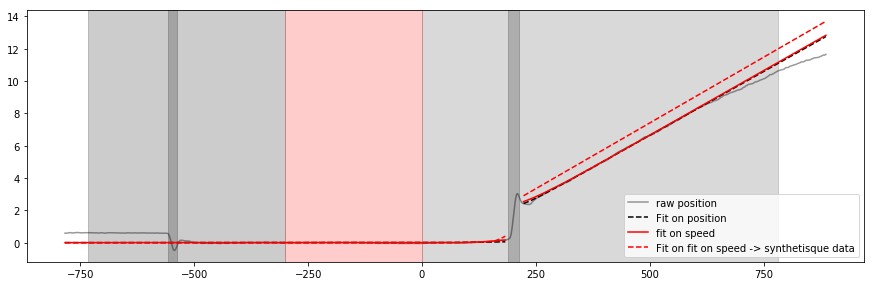

In [9]:
fig_width= 15
fig, axs = plt.subplots(1, 1, figsize=(fig_width, (fig_width/2)/1.6180))

deco(axs)
axs.plot(time-start, data_1, color='k', alpha=0.4, label='raw position')
axs.plot(time-start, d , '--k', label='Fit on position')
axs.plot(time-start, popo, color='r', label='fit on speed')
axs.plot(time-start, f , '--r', label='Fit on fit on speed -> synthetic data')
axs.legend();

In [10]:
block = 0
num1, num2 = 0, 200

fifi = {'start_anti' : [], 'v_anti' : [], 'latence' : [], 'tau' : [], 'maxi' : []}

for trial in np.arange(num1,num2) :
    
    print(trial)

    arg1 = ANEMO.arg(data, file_exp, trial, block)

    kwarg = {'TargetOn' : arg1.TargetOn, 'StimulusOf' : arg1.StimulusOf,
        'saccades' : arg1.saccades, 'px_per_deg' : arg1.px_per_deg}
    
    
    trial_data = trial + arg1.N_trials*block

    time = arg1.trackertime
    start = arg1.TargetOn
    start1 = start-time[0]
    
    popo = position(np.arange(len(time)), arg1.bino, param['start_anti'][block][trial]+start1,
                    param['v_anti'][block][trial], param['latence'][block][trial]+start1,
                    param['tau'][block][trial], param['maxi'][block][trial],
                    trial_data, arg1.px_per_deg, nan=True)

    c = Fit_position(popo, time, arg1.bino, trial_data, sup=False, time_sup=-280,
                     step=2, nan=True, **kwarg)
    
    
    fifi['start_anti'].append(c.values['start_anti']-start1)
    fifi['v_anti'].append(c.values['v_anti'])
    fifi['latence'].append(c.values['latence']-start1)
    fifi['tau'].append(c.values['tau'])
    fifi['maxi'].append(c.values['maxi'])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


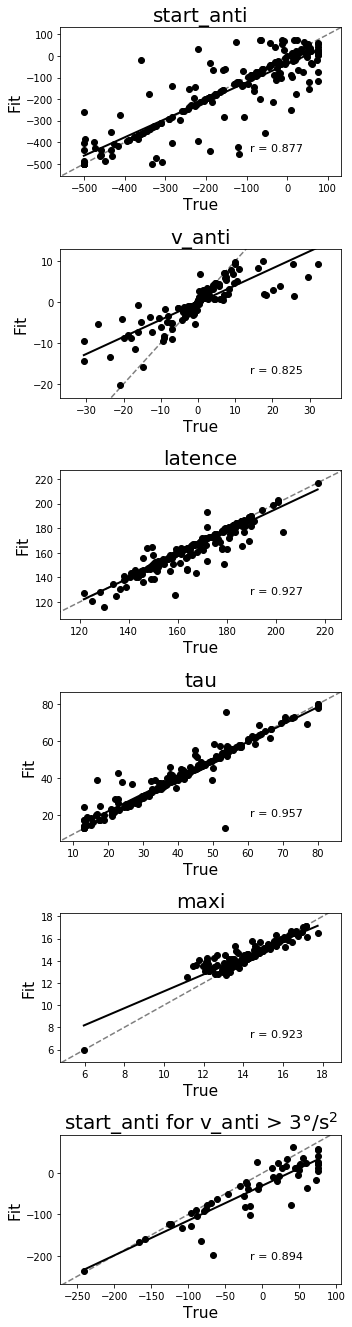

In [12]:
fig_width= 5
fig, axs = plt.subplots(6, 1, figsize=(fig_width, 6*(fig_width)/1.6180))

t_titre = 20

liste = ['start_anti', 'v_anti', 'latence', 'tau', 'maxi']
for a, tchoutchou in enumerate(liste) :
    axs[a].set_title('%s'%tchoutchou, fontsize=t_titre)
    axs[a].set_xlabel('True', fontsize=t_titre/1.3)
    axs[a].set_ylabel('Fit', fontsize=t_titre/1.3)
    
    axs[a].plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)
    
    axs[a].scatter(param['%s'%tchoutchou][block][num1:num2], fifi['%s'%tchoutchou], c='k')

    min_x, min_y = min(param['%s'%tchoutchou][block][num1:num2]), min(fifi['%s'%tchoutchou])
    max_x, max_y = max(param['%s'%tchoutchou][block][num1:num2]), max(fifi['%s'%tchoutchou])
    axs[a] = regress(axs[a], param['%s'%tchoutchou][block][num1:num2], fifi['%s'%tchoutchou], min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
    axs[a].axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)]) 


seuil = 3
new_start_anti_fit = []
new_start_anti_true = []
for s in range(num2) :
    if abs(param['v_anti'][block][s]) > seuil :
        if abs(fifi['v_anti'][s]) > seuil :
            new_start_anti_fit.append(fifi['start_anti'][s])
            new_start_anti_true.append(param['start_anti'][block][s])
            
axs[5].set_title('start_anti for v_anti > 3°/s$^2$', fontsize=t_titre)
axs[5].set_xlabel('True', fontsize=t_titre/1.3)
axs[5].set_ylabel('Fit', fontsize=t_titre/1.3)

axs[5].plot([-2000, 2000], [-2000, 2000], '--k', alpha=0.5)

axs[5].scatter(new_start_anti_true, new_start_anti_fit, c='k')

min_x, min_y = min(new_start_anti_true), min(new_start_anti_fit)
max_x, max_y = max(new_start_anti_true), max(new_start_anti_fit)
axs[5] = regress(axs[5], new_start_anti_true, new_start_anti_fit, min_x, min_y, max_x, max_y, t_label=t_titre/1.5)
axs[5].axis([min_x-((max_x-min_x)/10), max_x+((max_x-min_x)/10), min_y-((max_y-min_y)/10), max_y+((max_y-min_y)/10)]) 

plt.tight_layout();